In [1]:
import json
import csv
import numpy
import pytz
import pandas as pd
from binance.client import Client
import spacy
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import datetime

%matplotlib inline

In [2]:
coin = 'EOS' #getting plots for this coin.

# Get the coin price data from Binance.

In [3]:
coinfile = "coins_on_binance.csv"
with open(coinfile) as cf:
        rdr = csv.reader(cf)
        coins = []
        for row in rdr:
            coins.append(row)

Set up the Binance API to get the data we need.

In [4]:
client = Client("", "")

interval = Client.KLINE_INTERVAL_1MINUTE
start = "1 January, 2018"
end = "7 January, 2018"

The following function will get the historical price data for a given symbol (e.g. ETH) over the time interval.

In [5]:
def get_price_data(symbol):
    sym = symbol + "BTC"
    klines = client.get_historical_klines(sym, interval, start, end)

    j = []
    for t in klines:
        row = [t[6], t[4], t[2], t[3], t[5], t[8]]
        j.append(row)
    return j

Each output has the follow structure
[Close time, Close price, High, Low, Volume, Number of trades]

In [6]:
def get_all_price_data():
    prices = {}
    for c in coins:
        row = get_price_data(c[1])
        prices[c[1]] = row
    with open("all_prices.json", "w") as f:
        json.dump(prices, f)

In [7]:
with open("all_prices.json") as f:
    all_prices = json.load(f)

In [8]:
def plot_price(cur):
    price_df = pd.DataFrame(all_prices[cur])
    price_df.head()
    price_df = price_df.astype(float)
    price_df.plot.line(x=0, y=1)

# Reddit comment sentiment

In [9]:
filename = "RC_2018-01-01to06_crypto"
nlp = spacy.load('en')
occurances = {}

Get a list of coins on Binance:

Divide the comments based on references to coins:

In [10]:
def new_occurances():
    with open (filename) as f:
        all_data = json.load(f)
    for rc in all_data:
        spcomment = nlp(rc['body'])
        for symbol_line in coins:
            symbol = symbol_line[1]
            name = symbol_line[0]
            has_symbol = False  
            comment_dict = {'time': rc['created_utc'], 'body': rc['body'],
                             'sentences' : [], 'subreddit': rc['subreddit']}
            for sentence in spcomment.sents:
                for word in sentence:
                    if word.text.lower() == symbol.lower() or word.text.lower() == name.lower():
                        has_symbol = True
                        comment_dict['sentences'].append(sentence.text)
                        break
            if has_symbol:
                if symbol in occurances:
                    occurances[symbol].append(comment_dict)
                else:
                    occurances[symbol] = [comment_dict]

Sentiment:

In [11]:
goodwords = []
badwords = []

with open("good-words") as f:
    goodwords = [line.rstrip() for line in f]

with open("bad-words") as f:
    badwords = [line.rstrip() for line in f]


In [12]:
def check_sentiment(comment):
    good = 0
    bad = 0
    words = comment.lower().split()
   
    c = Counter(words)
    for g in goodwords:
        if g in words:
           
            good += c[g]
    for b in badwords:
        if b in words:
           
            bad += c[b]
    return good-bad, good, bad

In [13]:
def sentiment_comments_file():
    new_occurances()
    for coin in occurances:
        for comment in occurances[coin]:
            comment['sentiment'], comment['good'], comment['bad'] = check_sentiment(comment['body'])

    with open("sentiment_comments.json", "w") as f:
        json.dump(occurances, f)

In [14]:
with open("sentiment_comments.json") as f:
    occurances = json.load(f)

Plotting things:

In [15]:
def plot_mentions(symbol_data, symbol):
    symoccurances_df = pd.DataFrame(symbol_data)
    symoccurances_df.plot(kind= 'bar' , x = 'time', y = 'sentiment', color='blue')

In [16]:
def plot_length(symbol_data, symbol):
    for c in symbol_data:
        clen = 0
        for sentence in c['sentences']:
            clen += len(sentence)

        c['length'] = clen
       

    df = pd.DataFrame(symbol_data)
    
    df.head()
    df.plot(x = 'time', y ='length')

In [17]:
def plot_sentiment(symbol_data, symbol, sentiment):
    symoccurances_df = pd.DataFrame(symbol_data)
#     Convert time to datetime type, it is in second format
    symoccurances_df['time'] = symoccurances_df['time'].astype('datetime64[s]')
    symoccurances_df.head()
    symoccurances_df.plot(x = 'time', y = sentiment)
    
  

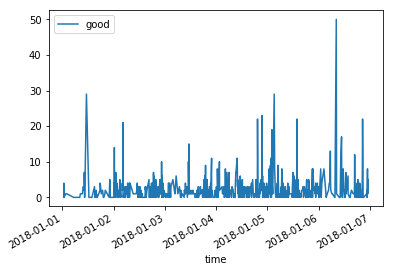

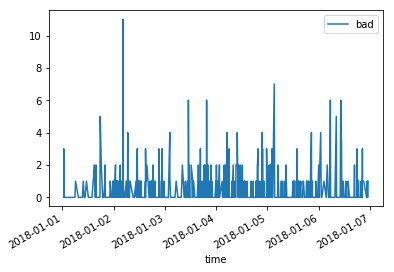

In [18]:
plot_sentiment(occurances[coin], coin, 'good')
plot_sentiment(occurances[coin], coin, 'bad')

Sentiment is still set to be good - bad.

In [19]:
def plot_sentiment_both(cur):

    symbol_data = occurances[cur]
    mydf = pd.DataFrame(symbol_data)
    mydf['time'] = mydf['time'].astype('datetime64[s]')
    mydf.head()

    mydf.plot(x = 'time', y = 'sentiment')

## Plot both good and bad on the same axes

In [20]:
def good_and_bad_plot1(cur):
    # Sort out the sentiment data
    symbol_data = occurances[cur]
    mydf = pd.DataFrame(symbol_data)
    mydf['time'] = mydf['time'].astype('datetime64[s]')

    # Plot both of them
    plt.plot(mydf.time, mydf.good)
    plt.plot(mydf.time, mydf.bad)
    plt.show()

In [21]:
def good_and_bad_plot2(cur):
    # Sort out the sentiment data
    symbol_data = occurances[cur]
    mydf = pd.DataFrame(symbol_data)
    mydf['time'] = mydf['time'].astype('datetime64[s]')
    mydf['bad'] = mydf['bad'] * -1

    # Plot both of them
    plt.plot(mydf.time, mydf.good)
    plt.plot(mydf.time, mydf.bad)
    plt.show()

## Plotting sentiment and cost


In [22]:
def overlay_plot(cur):
    # Sort out the sentiment data
    symbol_data = occurances[cur]
    mydf = pd.DataFrame(symbol_data)
    mydf['time'] = mydf['time'].astype('datetime64[s]')

    # Sort out cost data
    price_df = pd.DataFrame(all_prices[cur])
    price_df = price_df.astype(float)
    # Convert the float into a datetime. It is in ms format.
    price_df[0] = price_df[0].astype('datetime64[ms]')
    # Filter it to only do this day
    price_df[0] = price_df[(price_df[0] > '2018-01-01 00:00:00') & (price_df[0] < '2018-01-08 00:00:01')]


    #mydf['good']


    fig = plt.figure() # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx()

    mydf['bad'] = mydf['bad'] * -1
    mydf.plot(x='time', y='good', kind='line', ax=ax)
    mydf.plot(x='time', y='bad', kind='line', ax=ax)
    price_df.plot(x=0, y=1, kind='line', ax=ax2, color='red')
    plt.title(cur)
    plt.show()
    
   
   # fig.savefig(cur + "_overlayplot.png")
    #plt.close()
  

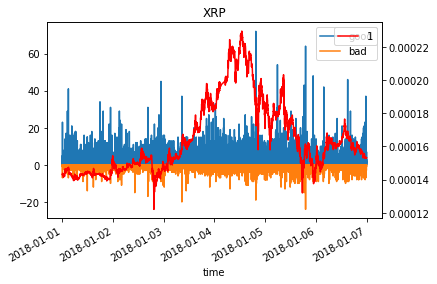

In [23]:
#for c in coins:
 #   if c[1] in occurances and len(all_prices[c[1]]) > 0:
  #      overlay_plot(c[1])"""

overlay_plot('XRP')

# Binning

In [24]:
occurances_binned = {}

occurances_binned = occurances
for coin in occurances_binned:
    for c in occurances_binned[coin]:
        rel_time = c['time'] - 1514764800
        bin_time = rel_time //300
        c['time_since'] = rel_time
        c['binned_time'] = bin_time


for coin in all_prices:
    for c in all_prices[coin]:
        bin_time = ((c[0]//1000) - 1514764800) /300
        c[0] = bin_time


In [92]:
def overlay_plot_bins(cur):
    # Sort out the sentiment data
    symbol_data = occurances_binned[cur]
    mydf = pd.DataFrame(symbol_data)
   
    #mydf['binned_time'] = mydf['binned_time'].astype('datetime64[s]')

    # Sort out cost data
    price_df = pd.DataFrame(all_prices[cur])
    price_df = price_df.astype(float)
    # Convert the float into a datetime. It is in ms format.
    #price_df[0] = price_df[0].astype('datetime64[ms]')
    # Filter it to only do this day
    #price_df[0] = price_df[(price_df[0] > '2018-01-01 00:00:00') & (price_df[0] < '2018-01-08 00:00:01')]

    fig = plt.figure() # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx()
    print(mydf)
    mydf['bad'] = mydf['bad'] * -1
    mydf = mydf.groupby('binned_time').sum()

 
    mydf.plot( y = 'good', kind='bar',  ax=ax, color = 'blue')
    mydf.plot( y='bad', kind='bar', ax=ax, color= 'orange')
    price_df.plot(x=0, y=1, kind='line', ax=ax2, color='red')
    plt.title(cur)
    #fig.savefig(cur + "_overlay_5min.png")
    plt.show()

In [93]:
#for coin in coins:
#    if coin[1] in occurances_binned and len(all_prices[coin[1]]) > 0:
#        overlay_plot_bins(coin[1])

     bad  binned_time                                               body  \
0      0           14                ETH ;), OMG, AION, ICON, Wanchain,    
1      0           16                        Aion is one my biggest bags   
2      0           16  Keep in mind vitalik is an advisor to Nuco whi...   
3      0           17                                               Aion   
4      0           22  I'll take a look into aion then, thanks. Long ...   
5      0           27                       AION, ICON and Simple Token.   
6      0           31  Everyone's always asking about low market cap ...   
7      0           53                                          aion/icon   
8      0           58  How does this stack up against the competition...   
9      0           64  &gt; Vitalik is a genius who placed in nationa...   
10     0           83  A few have discussed it. \n\nI like ENG, ICX, ...   
11     0          120  ICX, XLM, XRB, REQ, AION, SUB, XBY, ETH, IOTA,...   
12     0    

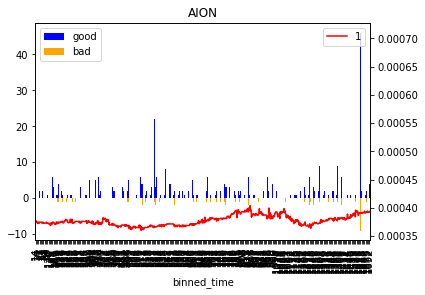

In [94]:
overlay_plot_bins("AION")